In [1]:
import argparse
import random
import numpy as np
import pandas as pd
import pickle
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from pathlib import Path
from utils import *
from model.metric import evaluate, predicate, acc, LSR
from model.data import DAdataset
from model.net import LSTMClassifier
from model.utils import remove_punct, sent_tokenize, lemmatize, preprocess_text
from torch.utils.tensorboard import SummaryWriter

In [2]:
data_dir = Path('dataset')
train_data_name = 'sw_train.txt'
valid_data_name = 'sw_val.txt'
test_data_name = 'sw_test.txt'
pretrained_embeddings_name = 'embeddings.pkl'
token2idx_name = 'word2idx.json'
label2idx_name = 'label2idx.json'
config_name = 'config.json'

In [3]:
args = {
    "epochs": 30,
    "n_batch": 64,
    "max_len": 256,
    "lr": 1e-5,
    "summary_step": 10000,
    "embedding_dim": 512,
    "hidden_size": 512,
    "n_layers": 1,
    "save_dir": 'experiment'
}
args = argparse.Namespace(**args)
print(args)

Namespace(embedding_dim=256, epochs=20, hidden_size=512, lr=0.005, max_len=30, n_batch=500, n_layers=2, save_dir='experiment', seed=2021, summary_step=10000)


In [4]:
with open(data_dir / pretrained_embeddings_name, 'rb') as f:
    pretrained_embeddings = pickle.load(f)
    
with open(data_dir / token2idx_name, 'r') as f:
    token2idx = json.load(f)
    
with open(data_dir / label2idx_name, 'r') as f:
    label2idx = json.load(f)
    
with open(data_dir / config_name, 'r') as f:
    config = json.load(f)
    
idx2token = {i:t for t,i in token2idx.items()}
idx2label = {i:l for l,i in label2idx.items()}

## Train

In [5]:
train_data = pd.read_csv(data_dir / train_data_name, header=None, sep='|', names=['speaker','utterance','tag'])
valid_data = pd.read_csv(data_dir / valid_data_name, header=None, sep='|', names=['speaker','utterance','tag'])


x_train, y_train = train_data['utterance'], train_data['tag']
x_valid, y_valid = valid_data['utterance'], valid_data['tag']

text_preprocess_pipeline = [remove_punct, sent_tokenize, lemmatize]

x_train = x_train.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)
x_valid = x_valid.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)

In [6]:
x_train = list(convert_token_to_idx(x_train, token2idx))
x_valid = list(convert_token_to_idx(x_valid, token2idx))

y_train = list(convert_label_to_idx(y_train, label2idx))
y_valid = list(convert_label_to_idx(y_valid, label2idx))

In [7]:
tr_ds = DAdataset(x_train, y_train)
tr_dl = DataLoader(tr_ds, batch_size=args.n_batch, collate_fn=tr_ds.collate_fn, shuffle=True, drop_last=True)

val_ds = DAdataset(x_valid, y_valid)
val_dl = DataLoader(val_ds, batch_size=args.n_batch, collate_fn=val_ds.collate_fn, shuffle=True, drop_last=True)

In [8]:
learning_rate = args.lr
batch_size = args.n_batch
vocab_size = len(token2idx)
embedding_dim = args.embedding_dim
hidden_size = args.hidden_size
output_size = len(label2idx)
n_layers = args.n_layers
dropout = 0.7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(batch_size, output_size, hidden_size, vocab_size, n_layers, embedding_dim, device,
                       dropout=dropout, bidirectional=True) #, weights=torch.from_numpy(pretrained_embeddings))

loss_fn = LSR(epsilon=0.1, num_classes=output_size)

if device.type == 'cuda':
    torch.cuda.empty_cache()

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)

writer = SummaryWriter(f'{args.save_dir}/runs')
checkpoint_manager = CheckpointManager(args.save_dir)
summary_manager = SummaryManager(args.save_dir)

In [9]:
best_val_loss = 1e+10
train_acc = []
valid_acc = []
train_losses = []
valid_losses = []

for epoch in tqdm(range(args.epochs), desc='epochs'):
    tr_loss = 0
    tr_acc = 0
    model.train()
    
    for step, mb in tqdm(enumerate(tr_dl), desc='epochs', total=len(tr_dl)):
        x_mb, y_mb = map(lambda elm: elm.to(device), mb)
        
        optimizer.zero_grad()
        y_hat_mb = model(x_mb)
        loss = loss_fn(y_hat_mb, y_mb)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            mb_acc = acc(y_hat_mb, y_mb)
        
        clip_gradient(model, 1e-1)
        
        tr_loss += loss.item()
        tr_acc += mb_acc.item()
        
        if (epoch*len(tr_dl)+step) % args.summary_step == 0:
            val_loss = evaluate(model, val_dl, {'loss':loss_fn}, device)['loss']
            writer.add_scalars('loss', {'train': tr_loss / (step + 1), 'val': val_loss}, epoch*len(tr_dl) + step)
            tqdm.write('global_Step: {:3}, tr_loss: {:3f}, val_loss: {:3f}'.format(epoch* len(tr_dl) + step,
                                                                                       tr_loss / (step + 1),
                                                                                       val_loss))
            model.train()
    
    else:
        tr_loss  /= (step + 1)
        tr_acc /= (step + 1)
        train_losses.append(tr_loss)
        train_acc.append(tr_acc)
        
        tr_sum = {'loss': tr_loss, 'acc': tr_acc}
        val_sum = evaluate(model, val_dl, {'loss': loss_fn, 'acc': acc}, device)
        tqdm.write('epoch : {}, tr_loss: {: 3f}, val_loss: '
                       '{:.3f}, tr_acc: {:.2%}, val_acc: {:.2%}'.format(epoch+1, tr_sum['loss'], val_sum['loss'],
                                                                        tr_sum['acc'], val_sum['acc']))
        
        val_loss = val_sum['loss']
        valid_losses.append(val_loss)
        valid_acc.append(val_sum['acc'])
        is_best = val_loss < best_val_loss
        
        if is_best:
            state = {
                'epoch': epoch+1, 
                'model_state_dict': model.state_dict(), 
                'opt_state_dict': optimizer.state_dict()
            }
            summary = {'tr': tr_sum, 'val': val_sum}
            summary_manager.update(summary)
            summary_manager.save('summary.json')
            checkpoint_manager.save_checkpoint(state, 'best.tar')
            best_val_loss = val_loss

steps: 100%|██████████| 6/6 [00:00<00:00, 24.00it/s]


global_Step:   0, tr_loss: 1.240493, val_loss: 0.804825


steps:  50%|█████     | 3/6 [00:00<00:00, 21.58it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 23.17it/s]


epoch : 1, tr_loss:  0.538331, val_loss: 0.383, tr_acc: 67.10%, val_acc: 68.89%


steps:  50%|█████     | 3/6 [00:00<00:00, 23.18it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 22.27it/s]

epoch : 2, tr_loss:  0.459697, val_loss: 0.385, tr_acc: 72.23%, val_acc: 68.40%


steps:  50%|█████     | 3/6 [00:00<00:00, 23.08it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 23.35it/s]


epoch : 3, tr_loss:  0.445562, val_loss: 0.371, tr_acc: 73.19%, val_acc: 68.73%


steps:  50%|█████     | 3/6 [00:00<00:00, 22.73it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 22.99it/s]


epoch : 4, tr_loss:  0.435410, val_loss: 0.361, tr_acc: 73.56%, val_acc: 69.80%


steps:  50%|█████     | 3/6 [00:00<00:00, 23.08it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 24.69it/s]


epoch : 5, tr_loss:  0.428949, val_loss: 0.360, tr_acc: 73.85%, val_acc: 70.11%


steps:  50%|█████     | 3/6 [00:00<00:00, 23.08it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 22.99it/s]


epoch : 6, tr_loss:  0.422942, val_loss: 0.359, tr_acc: 74.21%, val_acc: 70.48%


steps:  50%|█████     | 3/6 [00:00<00:00, 24.39it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 23.53it/s]


epoch : 7, tr_loss:  0.417091, val_loss: 0.352, tr_acc: 74.46%, val_acc: 69.77%


steps:  50%|█████     | 3/6 [00:00<00:00, 24.00it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 23.26it/s]

epoch : 8, tr_loss:  0.411604, val_loss: 0.368, tr_acc: 74.79%, val_acc: 69.50%


steps:  50%|█████     | 3/6 [00:00<00:00, 21.90it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 23.53it/s]

epoch : 9, tr_loss:  0.406648, val_loss: 0.372, tr_acc: 75.05%, val_acc: 68.52%


steps:  50%|█████     | 3/6 [00:00<00:00, 21.36it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 22.60it/s]

epoch : 10, tr_loss:  0.401953, val_loss: 0.359, tr_acc: 75.28%, val_acc: 70.42%


steps:  50%|█████     | 3/6 [00:00<00:00, 24.00it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 23.44it/s]

epoch : 11, tr_loss:  0.396492, val_loss: 0.383, tr_acc: 75.62%, val_acc: 69.32%


steps:  50%|█████     | 3/6 [00:00<00:00, 23.44it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 23.44it/s]

epoch : 12, tr_loss:  0.390956, val_loss: 0.378, tr_acc: 75.87%, val_acc: 70.35%


steps:  50%|█████     | 3/6 [00:00<00:00, 21.28it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 23.26it/s]

epoch : 13, tr_loss:  0.385929, val_loss: 0.376, tr_acc: 76.21%, val_acc: 69.77%


steps:  50%|█████     | 3/6 [00:00<00:00, 20.83it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 22.77it/s]

epoch : 14, tr_loss:  0.379271, val_loss: 0.399, tr_acc: 76.54%, val_acc: 69.83%


steps:  50%|█████     | 3/6 [00:00<00:00, 23.26it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 22.99it/s]

epoch : 15, tr_loss:  0.375492, val_loss: 0.434, tr_acc: 76.94%, val_acc: 69.32%


steps:  50%|█████     | 3/6 [00:00<00:00, 22.73it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 15.29it/s]

epoch : 16, tr_loss:  0.370616, val_loss: 0.409, tr_acc: 77.15%, val_acc: 69.87%


steps:  50%|█████     | 3/6 [00:00<00:00, 25.42it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 23.14it/s]

epoch : 17, tr_loss:  0.365498, val_loss: 0.425, tr_acc: 77.48%, val_acc: 69.28%


steps:  50%|█████     | 3/6 [00:00<00:00, 22.90it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 23.17it/s]

epoch : 18, tr_loss:  0.360822, val_loss: 0.473, tr_acc: 77.79%, val_acc: 69.01%


steps:  50%|█████     | 3/6 [00:00<00:00, 24.19it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 22.56it/s]

epoch : 19, tr_loss:  0.358608, val_loss: 0.447, tr_acc: 77.96%, val_acc: 69.65%


steps:  50%|█████     | 3/6 [00:00<00:00, 24.07it/s]

steps: 100%|██████████| 6/6 [00:00<00:00, 23.56it/s]

epoch : 20, tr_loss:  0.353626, val_loss: 0.437, tr_acc: 78.23%, val_acc: 69.07%



In [10]:
summary

{'tr': {'loss': 0.41709123621694744, 'acc': 0.744604200279961},
 'val': {'loss': 0.3518830474766659, 'acc': 0.6977384204095034}}

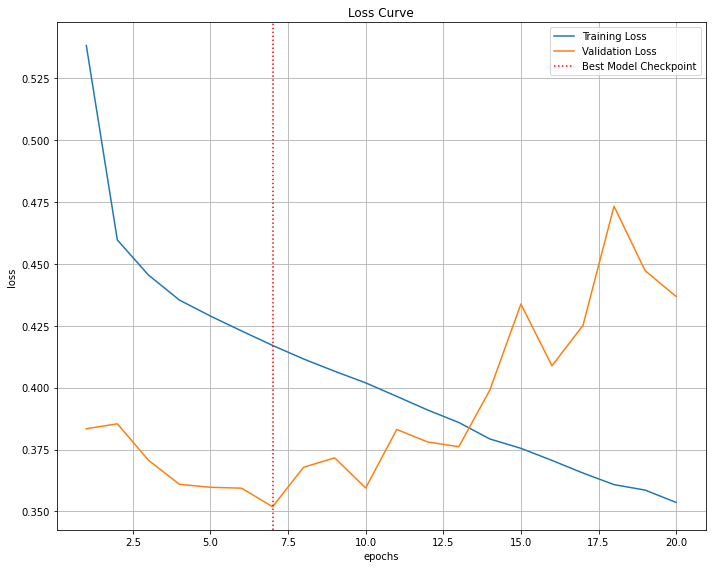

In [11]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Validation Loss')

minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='dotted', color='r',label='Best Model Checkpoint')

plt.title('Loss Curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(f'{args.save_dir}/loss_plot.png', bbox_inches = 'tight')

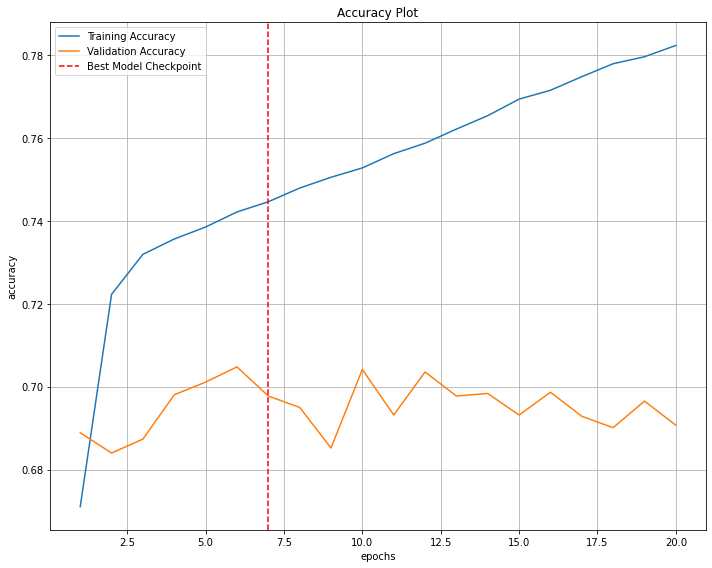

In [12]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1), train_acc, label='Training Accuracy')
plt.plot(range(1,len(valid_acc)+1), valid_acc, label='Validation Accuracy')

minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='--', color='r',label='Best Model Checkpoint')

plt.title('Accuracy Plot')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(f'{args.save_dir}/accuracy_plot.png', bbox_inches = 'tight')

## Evaluate

In [20]:
with open(data_dir / pretrained_embeddings_name, 'rb') as f:
    pretrained_embeddings = pickle.load(f)
    
with open(data_dir / token2idx_name, 'r') as f:
    token2idx = json.load(f)
    
with open(data_dir / label2idx_name, 'r') as f:
    label2idx = json.load(f)
    
with open(data_dir / config_name, 'r') as f:
    config = json.load(f)
    
idx2token = {i:t for t,i in token2idx.items()}
idx2label = {i:l for l,i in label2idx.items()}

learning_rate = args.lr
batch_size = 1
vocab_size = len(token2idx)
embedding_dim = args.embedding_dim
hidden_size = args.hidden_size
output_size = len(label2idx)
n_layers = args.n_layers
dropout = 0.7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(batch_size, output_size, hidden_size, vocab_size, n_layers, embedding_dim, device,
                       bidirectional=True) #, weights=torch.from_numpy(pretrained_embeddings))

model.to(device)
loss_fn = LSR(epsilon=0.1, num_classes=output_size)

In [21]:
writer = SummaryWriter(f'{args.save_dir}/runs')
checkpoint_manager = CheckpointManager(args.save_dir)
summary_manager = SummaryManager(args.save_dir)

ckpt = checkpoint_manager.load_checkpoint('best.tar')
model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [22]:
test_data = pd.read_csv(data_dir / test_data_name, header=None, sep='|', names=['speaker','utterance','tag'])

x_test, y_test = test_data['utterance'], test_data['tag']

text_preprocess_pipeline = [remove_punct, sent_tokenize, lemmatize]
x_test = x_test.apply(preprocess_text, processing_function_list=text_preprocess_pipeline)

x_test = list(convert_token_to_idx(x_test, token2idx))
y_test = list(convert_label_to_idx(y_test, label2idx))

test_ds = DAdataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=1, collate_fn=test_ds.collate_fn, drop_last=False)

In [23]:
summ = evaluate(model, test_dl, {'loss': loss_fn, 'acc': acc}, device)

summary_manager = SummaryManager(args.save_dir)
summary_manager.load('summary.json')
summary_manager.update(summ)
summary_manager.save('summary.json')

print('loss: {:3f}, acc: {:.2%}'.format(summ['loss'], summ['acc']))

steps: 100%|██████████| 4078/4078 [00:06<00:00, 675.83it/s]

loss: 0.649805, acc: 58.07%


### Make predictions

In [24]:
y_temp = [0]*len(x_test)
test_ds = DAdataset(x_test, y_temp)
test_dl = DataLoader(test_ds, batch_size=1) #, collate_fn=test_ds.collate_fn, shuffle=False, drop_last=False)
predicates = predicate(model, test_dl, device)

steps: 100%|██████████| 4078/4078 [00:05<00:00, 788.43it/s]


In [25]:
y_pred = [idx2label[p] for p in predicates]
test_data['prediction'] = y_pred
test_data.head(50)

,speaker,utterance,tag,prediction
0,A,"Okay, uh,","fo_o_fw_""_by_bc",sd
1,A,could you tell me what you think contributes m...,qw,qy
2,B,"Well, it's hard to say.",^h,sv
3,B,"I mean, while it's certainly the case that thi...",sv,sv
4,B,What do you think?,qo,qw
5,A,"Um, well, you talked about, uh, volcanos.",sd,sd
6,A,I'm not sure how many active volcanos there ar...,sd,sd
7,A,"I think probably the greatest cause is, uh, ve...",sv,sv
8,B,Uh-huh.,b,b
9,A,"Um, uh, do you live right in the city itself?",qy,qy


In [19]:
np.mean(np.array(y_pred) == np.array(y_true))

NameError: name 'y_true' is not defined

https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222
https://quokkas.tistory.com/entry/pytorch%EC%97%90%EC%84%9C-EarlyStop-%EC%9D%B4%EC%9A%A9%ED%95%98%EA%B8%B0
https://simonjisu.github.io/nlp/2018/07/05/packedsequence.html
https://nbviewer.jupyter.org/github/simonjisu/pytorch_tutorials/blob/master/00_Basic_Utils/02_PackedSequence.ipynb

데이터 전처리: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=qbxlvnf11&logNo=221434157182

pretrained 사용: https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222